# Predictive Modeling on Cancer Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [30]:
cancer = pd.read_csv("Breast Invasive Carcinoma (TCGA, Provisional).csv")

In [31]:
target_threshold = 32
cancer["survival"] = ""

In [32]:
def setup_target_variable(df, target_column, new_column, threshold):
    '''Changes the target variable values based on the threshold'''

    df.loc[df[target_column].values > threshold, new_column] = 1    # 1 - above the threshold
    df.loc[df[target_column].values <= threshold, new_column] = 0   # 0 - below the threshold

    return df 

In [33]:
cancer = setup_target_variable(cancer, 'OS MONTHS', 'survival', target_threshold)

In [34]:
print np.unique(cancer.survival)

[0 1 '']


In [35]:
features_chosen_by_domain_knowledge = ['AGE', 'AJCC METASTASIS PATHOLOGIC PM', 'AJCC NODES PATHOLOGIC PN', 'AJCC PATHOLOGIC TUMOR STAGE', 'AJCC TUMOR PATHOLOGIC PT', 'ETHNICITY', 'GENDER', 'HISTORY NEOADJUVANT TRTYN', 'HISTORY OTHER MALIGNANCY', 'ICD 10', 'ICD O 3 HISTOLOGY', 'ICD O 3 SITE']
#cancer = cancer[features_chosen_by_domain_knowledge]

In [36]:
def convert_categorical_to_int(df, column_name):
	'''Convert categorical values into integers'''	

	categorical_values = df[column_name].value_counts().index.tolist()
	assigned_value = 0
	for value in categorical_values:
		df.loc[df[column_name] == value, column_name] = assigned_value
		assigned_value += 1

	return df

def handle_categorical_variables(df, list_of_columns):
    '''Converts the categorical variables in the list of columns to integers'''
    
    for column in list_of_columns:
        df = convert_categorical_to_int(df, column)
    
    return df

In [37]:

cancer = handle_categorical_variables(cancer, ['AJCC METASTASIS PATHOLOGIC PM', 'AJCC NODES PATHOLOGIC PN', 'AJCC PATHOLOGIC TUMOR STAGE', 'AJCC TUMOR PATHOLOGIC PT', 'ETHNICITY', 'GENDER', 'HISTORY NEOADJUVANT TRTYN', 'HISTORY OTHER MALIGNANCY', 'ICD 10', 'ICD O 3 HISTOLOGY', 'ICD O 3 SITE'])


In [38]:
print np.unique(cancer.survival)

[0 1 '']


In [39]:
def handle_na(df):
    '''Handle the NaN fields'''

    df['AGE'].fillna(df['AGE'].mean, inplace = True)
    df['AJCC METASTASIS PATHOLOGIC PM'].fillna(df['AJCC METASTASIS PATHOLOGIC PM'].value_counts()[0], inplace = True)
    df['AJCC NODES PATHOLOGIC PN'].fillna(df['AJCC NODES PATHOLOGIC PN'].value_counts()[0], inplace = True)
    df['AJCC PATHOLOGIC TUMOR STAGE'].fillna(df['AJCC PATHOLOGIC TUMOR STAGE'].value_counts()[0], inplace = True)
    df['AJCC TUMOR PATHOLOGIC PT'].fillna(df['AJCC TUMOR PATHOLOGIC PT'].value_counts()[0], inplace = True)
    df['ETHNICITY'].fillna(df['ETHNICITY'].value_counts()[0], inplace = True)
    df['GENDER'].fillna(df['GENDER'].value_counts()[0], inplace = True)
    df['HISTORY NEOADJUVANT TRTYN'].fillna(df['HISTORY NEOADJUVANT TRTYN'].value_counts()[0], inplace = True)
    df['HISTORY OTHER MALIGNANCY'].fillna(df['HISTORY OTHER MALIGNANCY'].value_counts()[0], inplace = True)
    df['ICD 10'].fillna(df['ICD 10'].value_counts()[0], inplace = True)
    df['ICD O 3 HISTOLOGY'].fillna(df['ICD O 3 HISTOLOGY'].value_counts()[0], inplace = True)
    df['ICD O 3 SITE'].fillna(df['ICD O 3 SITE'].value_counts()[0], inplace = True)
    
    return df 

In [40]:
print np.unique(cancer.survival)

[0 1 '']


In [41]:
cancer = handle_na(cancer)

print "Shape(Before removing NaN): ", cancer.shape
cancer_without_nan = cancer.dropna(subset = ['OS MONTHS'])
print "Shape(After removing NaN): ", cancer_without_nan.shape

#cancer_without_nan = cancer_without_nan.convert_objects(convert_dates=False, convert_numeric=True, convert_timedeltas=False, copy=True)

Shape(Before removing NaN):  (1105, 59)
Shape(After removing NaN):  (1006, 59)


In [18]:
sum(cancer['AGE'].isnull())

0

In [19]:
np.unique(cancer_without_nan.survival)

array([0, 1], dtype=object)

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import grid_search

In [43]:
def decision_tree_model_with_cv(features_list, training_data, target_data, k, hyperparam = None):
    if hyperparam != None: 
        decision_tree = DecisionTreeClassifier(criterion = 'entropy')
    else:
        decision_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = hyperparam.get_max_depth(), max_features = hyperparam.get_max_features(), min_samples_split = hyperparam.get_min_samples_split(), min_samples_leaf = hyperparam.get_min_samples_leaf())
    
    cv_score = cross_val_score(decision_tree, training_data[features_list], target_data.astype(int), scoring = 'roc_auc', cv=k)
    
    return cv_score.mean()

In [53]:
def logistic_regression_model_with_cv(features_list, training_data, target_data, k):
    lr = LogisticRegression()
    cv_score = cross_val_score(lr, training_data[features_list], target_data.astype(int), scoring = 'roc_auc', cv=k)
    
    return cv_score.mean()

In [54]:
def svm_model_with_cv(features_list, training_data, target_data, k):
    svm = SVC()
    cv_score = cross_val_score(svm, training_data[features_list], target_data.astype(int), scoring = 'roc_auc', cv=k)
    
    return cv_score.mean()

In [62]:
def rf_model_with_cv(features_list, training_data, target_data, k):
    rf = RandomForestClassifier()
    cv_score = cross_val_score(rf, training_data[features_list], target_data.astype(int), scoring = 'roc_auc', cv=k)
    
    return cv_score.mean()

In [22]:
tmp = np.asarray(cancer_without_nan.survival, dtype=np.int32)
print(np.unique(tmp))

[0 1]


In [56]:
# From domain knowledge, TUMOR_STAGE is arrived at by considering AJCC METASTASIS PATHOLOGIC PM, AJCC NODES PATHOLOGIC PN and AJCC TUMOR PATHOLOGIC PT

just_stage = ["AJCC PATHOLOGIC TUMOR STAGE"]
just_pathology = ['AJCC METASTASIS PATHOLOGIC PM', 'AJCC NODES PATHOLOGIC PN', 'AJCC TUMOR PATHOLOGIC PT']

# Decision Tree
dt_cv_auc_just_stage = decision_tree_model_with_cv(just_stage, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
dt_cv_auc_just_pathology = decision_tree_model_with_cv(just_pathology, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
dt_cv_auc_both = decision_tree_model_with_cv(just_stage + just_pathology, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)

print "Decision Tree"
print "JUST STAGE: ", dt_cv_auc_just_stage
print "JUST PATHOLOGY: ", dt_cv_auc_just_pathology
print "BOTH: ", dt_cv_auc_both

# Logistic Regression
lr_cv_auc_just_stage = logistic_regression_model_with_cv(just_stage, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
lr_cv_auc_just_pathology = logistic_regression_model_with_cv(just_pathology, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
lr_cv_auc_both = logistic_regression_model_with_cv(just_stage + just_pathology, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)

print "Logistic Regression"
print "JUST STAGE: ", lr_cv_auc_just_stage
print "JUST PATHOLOGY: ", lr_cv_auc_just_pathology
print "BOTH: ", lr_cv_auc_both

# SVM
svm_cv_auc_just_stage = svm_model_with_cv(just_stage, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
svm_cv_auc_just_pathology = svm_model_with_cv(just_pathology, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
svm_cv_auc_both = svm_model_with_cv(just_stage + just_pathology, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)

print "SVM"
print "JUST STAGE: ", svm_cv_auc_just_stage
print "JUST PATHOLOGY: ", svm_cv_auc_just_pathology
print "BOTH: ", svm_cv_auc_both

Decision Tree
JUST STAGE:  0.584231999857
JUST PATHOLOGY:  0.585712693721
BOTH:  0.628490190339
Logistic Regression
JUST STAGE:  0.507652984085
JUST PATHOLOGY:  0.610215870633
BOTH:  0.605308619632
SVM
JUST STAGE:  0.581783792721
JUST PATHOLOGY:  0.599520837802
BOTH:  0.581260445714


Note about the above observation: 
The results are consistent with the domain knowledge where the Stage is defined by the  combination of the three columns. The AUC of using either the stage or the the pathology features give almost the same value which is around 58%. But, using both improves the AUC by 4%. This can be attributed to the fact that every stage has multiple combinations of pathology columns. So, the combination is more specific. Hence, the improvement.

In [57]:
len(features_chosen_by_domain_knowledge)

12

In [63]:
dt_auc_with_cv = decision_tree_model_with_cv(features_chosen_by_domain_knowledge, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
lr_auc_with_cv = logistic_regression_model_with_cv(features_chosen_by_domain_knowledge, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
svm_auc_with_cv = svm_model_with_cv(features_chosen_by_domain_knowledge, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)
rf_auc_with_cv = rf_model_with_cv(features_chosen_by_domain_knowledge, cancer_without_nan.drop('survival', 1), cancer_without_nan.survival, 10)

print "AUC"
print "Decision Tree (10-Fold CV): ", dt_auc_with_cv
print "Logistic Regression (10-Fold CV): ", lr_auc_with_cv
print "SVM (10-Fold CV): ", svm_auc_with_cv
print "Random Forest (10-Fold CV): ", rf_auc_with_cv

AUC
Decision Tree (10-Fold CV):  0.562422988465
Logistic Regression (10-Fold CV):  0.544588375578
SVM (10-Fold CV):  0.520379698895
Random Forest (10-Fold CV):  0.569535020512


In [13]:
# Decision Tree Model Hyperparameters
class DT_HyperParam:
    
    def __init__(self, max_depth, min_samples_split, min_samples_leaf, max_features):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        
    def get_max_depth(self):
        return self.max_depth
    
    def get_min_samples_split(self):
        return self.min_samples_split
    
    def get_min_samples_leaf(self):
        return self.min_samples_leaf
    
    def get_max_features(self):
        return self.max_features

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
# Setting up the data for finding optimal hyperparameters


final_features = features_chosen_by_domain_knowledge + ['survival']

cancer_without_nan = cancer_without_nan[final_features]

rows = cancer_without_nan.shape[0]

training = cancer_without_nan.ix[ : 0.8 * rows, :]
testing = cancer_without_nan.ix[0.8 * rows: , :]

cancer_training = training.drop('survival', 1)
cancer_testing = testing.drop('survival', 1)
survival_training = training['survival']
survival_testing = testing['survival']

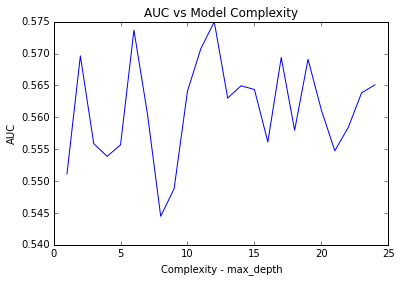

In [71]:
# Searching optimal hyperparameters for decision tree

# Using max_depth as the complexity parameter. As max_depth increases, the complexity increases

max_depth_values = np.arange(1, 25)
md_auc_scores = {}
for md in max_depth_values:
    dt_hyperparam = DT_HyperParam(md, 2, 1, None)
    md_auc_scores[md] = decision_tree_model_with_cv(features_chosen_by_domain_knowledge, cancer_training, survival_training, 10, hyperparam = dt_hyperparam)

plt.plot(md_auc_scores.keys(), md_auc_scores.values())
plt.xlabel("Max Depth")
plt.ylabel("AUC")
plt.title("AUC vs Model Complexity")

#### FINAL CONCLUSION ####
#### Max depth is not 

In [80]:
survival_training.shape

(756,)

In [86]:
# Decision Tree Grid Search
dt_parameters = {'max_depth':[1, 100], 'min_samples_split':[2, 6], 'min_samples_leaf':[1, 4]}
dt = DecisionTreeClassifier(criterion = "entropy")

dt_gs = grid_search.GridSearchCV(dt, dt_parameters, scoring = 'roc_auc', cv = 10)
dt_optimal = dt_gs.fit(cancer_training, survival_training.astype(int))
print dt_optimal

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': [2, 6], 'max_depth': [1, 100], 'min_samples_leaf': [1, 4]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)
